In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# constants (SI + cgs conversion for g)
G_SI   = 6.67430e-11
M_sun  = 1.98847e30

df = pd.read_csv("../data/white_dwarf_data.csv")

# columns: wdid, logg, mass
# logg is standard WD catalog convention: log10(g) with g in cm/s^2
g_cgs = 10.0**df["logg"].to_numpy()          # cm/s^2
g_SI  = g_cgs / 100.0                        # m/s^2

M_kg = df["mass"].to_numpy() * M_sun
R_m  = np.sqrt(G_SI * M_kg / g_SI)

df["R_m"] = R_m
df["R_km"] = R_m / 1000.0

print(df.head())
print("N =", len(df))

                           wdid   logg   mass           R_m          R_km
0       2MASS J10145164+4541479  7.455  0.301  1.183711e+07  11837.108576
1          2QZ J114947.9-012045  8.497  0.907  6.191074e+06   6191.074455
2                     GJ 1179 B  7.783  0.454  9.965298e+06   9965.298449
3  Gaia DR2 1007682723024253184  7.885  0.510  9.391770e+06   9391.770500
4  Gaia DR2 1010300965150157824  8.035  0.600  8.571129e+06   8571.128548
N = 378


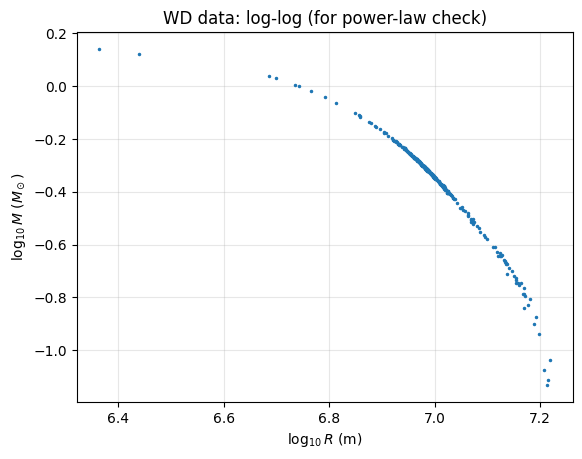

In [33]:
M = df["mass"].to_numpy()           # in Msun
R = df["R_m"].to_numpy()            # in m

plt.figure()
plt.plot(np.log10(R), np.log10(M), ".", markersize=3)
plt.xlabel(r"$\log_{10} R$ (m)")
plt.ylabel(r"$\log_{10} M$ ($M_\odot$)")
plt.title("WD data: log-log (for power-law check)")
plt.grid(True, alpha=0.3)
plt.show()

Chosen low-mass cut Mcut = 0.547655172413793 Msun
Fit: log10 M = slope * log10 R + intercept
slope = -2.5931213220408202 intercept = 17.798768564723957 R^2 = 0.9716005366940498


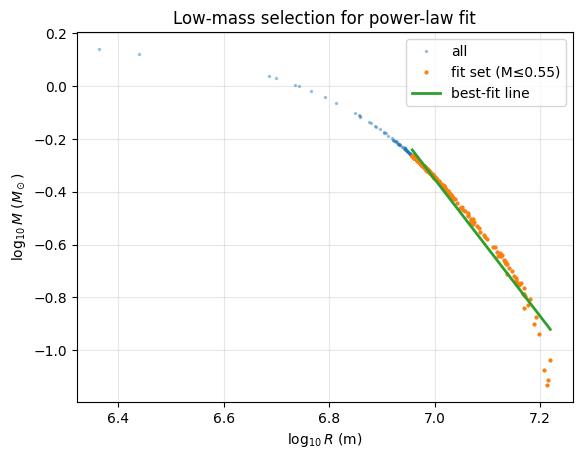

In [34]:
def linfit_stats(x, y):
    # y = a x + b
    a, b = np.polyfit(x, y, 1)
    yhat = a*x + b
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return a, b, r2, ss_res

logR = np.log10(R)
logM = np.log10(M)

# try mass cuts; require enough points
cuts = np.linspace(np.min(M)+0.02, 0.60, 30)
best = None

for mc in cuts:
    mask = (M <= mc) & np.isfinite(logR) & np.isfinite(logM)
    if np.sum(mask) < 25:
        continue
    a, b, r2, ss = linfit_stats(logR[mask], logM[mask])
    # pick highest R^2 (most power-law-like)
    if (best is None) or (r2 > best["r2"]):
        best = {"mc": mc, "a": a, "b": b, "r2": r2, "mask": mask}

mc = best["mc"]
mask = best["mask"]
slope = best["a"]
intercept = best["b"]

print("Chosen low-mass cut Mcut =", mc, "Msun")
print("Fit: log10 M = slope * log10 R + intercept")
print("slope =", slope, "intercept =", intercept, "R^2 =", best["r2"])

plt.figure()
plt.plot(logR, logM, ".", markersize=3, alpha=0.35, label="all")
plt.plot(logR[mask], logM[mask], ".", markersize=4, label=f"fit set (M≤{mc:.2f})")
xx = np.linspace(np.min(logR[mask]), np.max(logR[mask]), 200)
plt.plot(xx, slope*xx + intercept, "-", linewidth=2, label="best-fit line")
plt.xlabel(r"$\log_{10} R$ (m)")
plt.ylabel(r"$\log_{10} M$ ($M_\odot$)")
plt.title("Low-mass selection for power-law fit")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [35]:
# Newton (c) PDF hint: q = 3
q = 3
n_star = q / (5 - q)   # = 1.5
print("Using q=3 -> n* =", n_star)

Using q=3 -> n* = 1.5


In [36]:
from scipy.integrate import solve_ivp
import numpy as np

def lane_emden_constants(n, xi_max=200.0):
    # start near 0 with series
    xi0 = 1e-6
    theta0 = 1.0 - xi0**2/6.0
    phi0   = -xi0/3.0
    y0 = [theta0, phi0]  # [theta, theta']

    def rhs(xi, y):
        th, ph = y

        # if we crossed the surface (th <= 0), stop "driving" dynamics
        # (prevents th**n with fractional n giving NaN)
        if th <= 0.0:
            return [ph, 0.0]

        dth = ph
        dph = -2.0/xi * ph - th**n
        return [dth, dph]

    def event_zero(xi, y):
        # root at theta=0
        return y[0]

    event_zero.terminal = True
    event_zero.direction = -1  # only detect when theta decreases through 0

    sol = solve_ivp(
        rhs, (xi0, xi_max), y0,
        events=event_zero,
        rtol=1e-10, atol=1e-12,
        max_step=0.05
    )

    if sol.status != 1 or sol.t_events[0].size == 0:
        raise RuntimeError(f"Lane-Emden: theta did not hit zero up to xi_max={xi_max}.")

    xi1 = sol.t_events[0][0]
    th1, ph1 = sol.y_events[0][0]
    omega_n = - (xi1**2) * ph1  # -xi1^2 theta'(xi1)

    return xi1, omega_n

# n* fixed from hint q=3 -> n*=1.5
n_star = 1.5
xi1, omega_n = lane_emden_constants(n_star)
print("xi1 =", xi1)
print("omega_n =", omega_n)

xi1 = 3.653753736229732
omega_n = 2.714055163438723


In [37]:
# Convert fit intercept to SI relation:
# fit was: log10(M/Msun) = s log10(R/m) + intercept
# => M_kg = Msun * 10^intercept * R^s

A0 = (4.0*np.pi*omega_n) * (xi1**((3.0-n_star)/(n_star-1.0)))  # dimensionless factor

# From formula: M = A0 * (( (n+1)K / (4πG) )^(n/(n-1))) * R^s
# Solve for K:
# K = (4πG/(n+1)) * ( M/(A0 R^s) )^((n-1)/n)

pref = 4.0*np.pi*G_SI/(n_star+1.0)

# Use the fitted intercept (in base-10) to estimate K from the line:
# Pick a representative R (geometric mean) to avoid numerical issues; cancels anyway.
R_rep = 10.0**(np.mean(logR[mask]))
M_rep = (10.0**(s*np.log10(R_rep) + intercept)) * M_sun

K_star = pref * (M_rep / (A0 * (R_rep**s)))**((n_star-1.0)/n_star)

print("K* (SI) =", K_star)

K* (SI) = 305086.2707742207


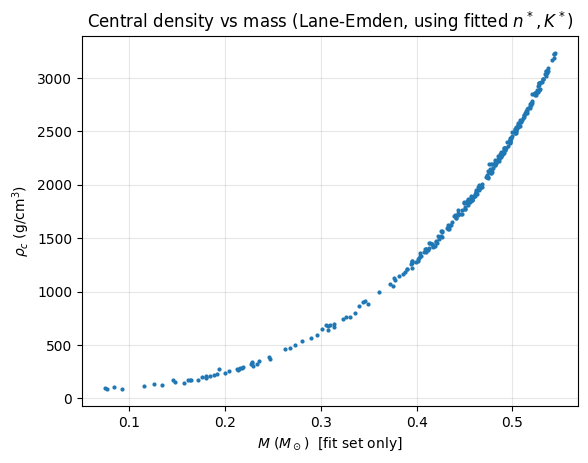

rho_c range (g/cm^3): 87.00397766419778 to 3233.7994544583294


In [38]:
M_fit = M[mask]          # Msun
R_fit = R[mask]          # m

rho_c_SI = (R_fit/xi1)**(2.0*n_star/(1.0-n_star)) * (4.0*np.pi*G_SI/((n_star+1.0)*K_star))**(n_star/(1.0-n_star))
rho_c_cgs = rho_c_SI / 1000.0  # kg/m^3 -> g/cm^3

plt.figure()
plt.plot(M_fit, rho_c_cgs, ".", markersize=4)
plt.xlabel(r"$M$ ($M_\odot$)  [fit set only]")
plt.ylabel(r"$\rho_c$ (g/cm$^3$)")
plt.title(r"Central density vs mass (Lane-Emden, using fitted $n^*,K^*$)")
plt.grid(True, alpha=0.3)
plt.show()

print("rho_c range (g/cm^3):", np.min(rho_c_cgs), "to", np.max(rho_c_cgs))